### Digits classification using Multi Layer Perceptron
A Multi-Layer Perceptron (MLP) is a feedforward neural network with multiple layers of neurons that utilize weighted connections and activation functions to learn complex mappings from inputs to outputs

The output of the MLP can be represented as:

$$
Z^{(1)} = W^{(1)} X + b^{(1)}
$$

$$
A^{(1)} = \text{ReLU}(Z^{(1)})
$$

$$
Z^{(2)} = W^{(2)} A^{(1)} + b^{(2)}
$$

$$
A^{(2)} = \sigma(Z^{(2)})
$$

Where:

- $W^{(1)}, W^{(2)}$: Weight matrices for the first and second layers.
- $b^{(1)}, b^{(2)}$: Bias vectors for the first and second layers.
- $X$: Input features.
- $A^{(1)}, A^{(2)}$: Activations for the first and second layers.
- $\text{ReLU}$: Rectified Linear Unit activation function.
- $\sigma$: Sigmoid activation function for binary classification ( softmax for multi class)


In [3]:
import gzip
import os
import numpy as np
import struct


def load_mnist(path, kind='train'):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path, f'{kind}-labels-idx1-ubyte.gz')
    images_path = os.path.join(path, f'{kind}-images-idx3-ubyte.gz')

    with gzip.open(labels_path, 'rb') as lbpath:
        _, _ = struct.unpack('>II', lbpath.read(8))
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8)

    with gzip.open(images_path, 'rb') as imgpath:
        _, num, rows, cols = struct.unpack('>IIII', imgpath.read(16))
        images = np.frombuffer(imgpath.read(), dtype=np.uint8).reshape(num, rows*cols)

    return images, labels

# Load the dataset
mnist_path = '../supplemental_material/MNIST'
X_train, y_train = load_mnist(mnist_path, kind='train')
X_test, y_test = load_mnist(mnist_path, kind='t10k')

print(f"Training set shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Test set shape: {X_test.shape}, Test labels shape: {y_test.shape}")    

Training set shape: (60000, 784), Training labels shape: (60000,)
Test set shape: (10000, 784), Test labels shape: (10000,)


Epoch [1/10], Loss: 1.9299
Epoch [2/10], Loss: 1.8987
Epoch [3/10], Loss: 1.7420
Epoch [4/10], Loss: 1.6174
Epoch [5/10], Loss: 1.8362
Epoch [6/10], Loss: 1.7737
Epoch [7/10], Loss: 1.8362
Epoch [8/10], Loss: 1.7737
Epoch [9/10], Loss: 1.8362
Epoch [10/10], Loss: 1.7424
Train Accuracy: 71.91%
Test Accuracy: 72.28%


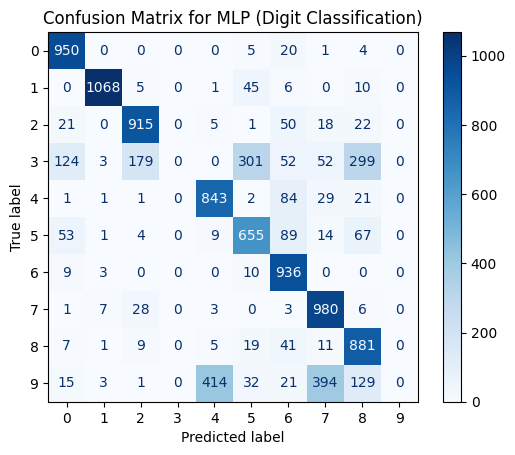

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)  

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.softmax(out)  
        return out

# Prepare the data
X_train = X_train.reshape(-1, 28 * 28).astype(np.float32)  # Reshape for MLP input
X_test = X_test.reshape(-1, 28 * 28).astype(np.float32) 

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)  

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]  # 28*28 for MNIST
hidden_size = 128
output_size = 10  # number of classes (0-9)

model = MLP(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()  # Cross Entropy Loss for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)  
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Save the model weights
save_path = os.path.join("data", "weights", "MLP")
os.makedirs(save_path, exist_ok=True)  
torch.save(model.state_dict(), os.path.join(save_path, "MNIST.pth"))

# Evaluation
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train_tensor).argmax(dim=1)  
    y_pred_test = model(X_test_tensor).argmax(dim=1)    

train_accuracy = (y_pred_train.eq(y_train_tensor).sum() / y_train_tensor.shape[0]).item()
test_accuracy = (y_pred_test.eq(y_test_tensor).sum() / y_test_tensor.shape[0]).item()

print(f'Train Accuracy: {train_accuracy * 100:.2f}%')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Confusion Matrix
y_pred_test_np = y_pred_test.numpy().flatten()
y_test_np = y_test_tensor.numpy().flatten()

cm = confusion_matrix(y_test_np, y_pred_test_np)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(10)])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for MLP (Digit Classification)')
plt.show()


### Digit Classification with LeNet
LeNet is a convolutional neural network (CNN) architecture that employs convolutional and subsampling layers to extract features from images, followed by fully connected layers for classification

The output of the LeNet Architecture can be represented as:

1. **Convolution and Activation:**
   $$
   Z^{(1)} = W^{(1)} * X + b^{(1)}
   $$
   $$
   A^{(1)} = \text{tanh}(Z^{(1)})
   $$

2. **Subsampling (Pooling):**
   $$
   A^{(2)} = \text{AvgPool}(A^{(1)})
   $$

3. **Second Convolution and Activation:**
   $$
   Z^{(3)} = W^{(3)} * A^{(2)} + b^{(3)}
   $$
   $$
   A^{(3)} = \text{tanh}(Z^{(3)})
   $$

4. **Second Subsampling (Pooling):**
   $$
   A^{(4)} = \text{AvgPool}(A^{(3)})
   $$

5. **Flattening:**
   $$
   A^{(5)} = \text{Flatten}(A^{(4)})
   $$

6. **Fully Connected Layer:**
   $$
   Z^{(6)} = W^{(6)} A^{(5)} + b^{(6)}
   $$
   $$
   A^{(6)} = \sigma(Z^{(6)})
   $$

Where:
- $W^{(l)}$: Weight matrices for each layer.
- $b^{(l)}$: Bias vectors for each layer.
- $X$: Input image.
- $\text{tanh}$: Hyperbolic tangent activation function.
- $\text{AvgPool}$: Average pooling operation.
- $\sigma$: Sigmoid activation function for binary classification ( softmax for multiclass)

Flattening transforms a multi-dimensional tensor into a one-dimensional vector, preparing feature maps for input into fully connected layers in neural networks.

In [10]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define LeNet-5 architecture
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)  
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)            
        self.fc1 = nn.Linear(16 * 5 * 5, 120)                            
        self.fc2 = nn.Linear(120, 84)                                   
        self.fc3 = nn.Linear(84, 10)                                     # Output layer for 10 classes

    def forward(self, x):
        x = torch.relu(self.conv1(x))  
        x = torch.max_pool2d(x, kernel_size=2, stride=2)  
        x = torch.relu(self.conv2(x))  
        x = torch.max_pool2d(x, kernel_size=2, stride=2) 
        x = x.view(-1, 16 * 5 * 5)  
        x = torch.relu(self.fc1(x))  
        x = torch.relu(self.fc2(x))  
        x = self.fc3(x) 
        return x

# Transform the data to tensor and normalize
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the dataset
X_train, y_train = load_mnist(mnist_path, kind='train')  
X_test, y_test = load_mnist(mnist_path, kind='t10k')  

# Reshape data to (n_samples, 1, 28, 28) for PyTorch Conv2D
X_train = X_train.reshape(-1, 1, 28, 28).astype(np.float32) 
X_test = X_test.reshape(-1, 1, 28, 28).astype(np.float32)   

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train).long() 
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test).long()   

# Create datasets and data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Instantiate the model, define the loss function and the optimizer
model = LeNet5()
criterion = nn.CrossEntropyLoss()  # Cross Entropy Loss for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Save the model weights
save_path = os.path.join("data", "weights", "LeNet5")
os.makedirs(save_path, exist_ok=True)  
torch.save(model.state_dict(), os.path.join(save_path, "MNIST.pth"))

Epoch 1/10, Loss: 0.1654
Epoch 2/10, Loss: 0.0621
Epoch 3/10, Loss: 0.0477
Epoch 4/10, Loss: 0.0401
Epoch 5/10, Loss: 0.0366
Epoch 6/10, Loss: 0.0308
Epoch 7/10, Loss: 0.0279
Epoch 8/10, Loss: 0.0231
Epoch 9/10, Loss: 0.0245
Epoch 10/10, Loss: 0.0211


Accuracy: 98.69%


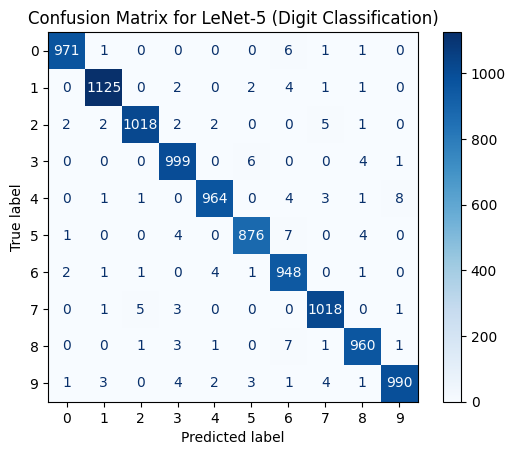

In [12]:
# Evaluation
model.eval()
correct = 0
total = 0
all_predictions = []  
all_labels = []      

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)  # Get the predicted class indices
        all_predictions.extend(predicted.numpy())    # Collect predictions
        all_labels.extend(y_batch.numpy())           # Collect true labels
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

print(f'Accuracy: {100 * correct / total:.2f}%')

# Confusion Matrix
y_pred_test_np = np.array(all_predictions)  
y_test_np = np.array(all_labels)             

cm = confusion_matrix(y_test_np, y_pred_test_np)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(10)])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for LeNet-5 (Digit Classification)')
plt.show()
